# Example workflow using PBE and ADAPT-VQE and QNG(SPSA)

> PBE = Projection-Based Embedding

> ADAPT-VQE = Adaptive Derivative Assembled Pseudo-Trotter Variational Quantum Eigensolver

> QNG = Quantum Natural Gradient 

- Choose a molecule to simulate, in this case $\mathrm{H}_2\mathrm{O}$
- Embed some subdomain of the molecule, in this case one of the $\mathrm{O} - \mathrm{H}$ bonds.
- Get the various objects required for a quantum simulation:
    - The Hamiltonian whose ground state we are aiming to estimate;
    - The Hartree-Fock state to use as reference to initialize our circuits;
    - The cluster operator to define the excitations used in the ansatz circuit.
- Then, run an ADAPT-VQE routine to iteratively build an ansatz circuit -- this approach has some favourable properties, for example we can control how deep the circuits get and it should be resilient to barren plateaus, since each ADAPT cycle is warm-started from the solution of the previous iteration.
- We can play different optimization methods like QNG and QNG-SPSA for faster convergence and less shots.
- We can also play various optimization tricks on the resulting circuits (e.g. with ZX calculus).

### We go through each of these steps below:

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
import numpy as np
from pyscf import gto, scf, qmmm, fci, cc
from nbed.ham_builder import HamiltonianBuilder, get_coupled_cluster_operator
from nbed.utils import list_to_xyz
from nbed.driver import NbedDriver
from nbed.variational_optimization import ADAPT_VQE, VQE_Driver
from symmer import PauliwordOp, QubitTapering
from symmer.utils import exact_gs_energy
from symmer.evolution import PauliwordOp_to_QuantumCircuit

geom = [
    ("O",(0,0,0)),
    ("H",(0.952519,0,0)),
    ("H",(-0.246530058, 0.9200627021, 0))
]

2024-10-16 17:18:07,336	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/maidaw/ray_results/PPO_2024-10-16_17-17-18' in 0.0221s.
2024-10-16 17:18:07,961	INFO tune.py:1048 -- Total run time: 49.63 seconds (48.97 seconds for the tuning loop).


AttributeError: 'ResultGrid' object has no attribute 'get_best_checkpoint'

Having defined the molecule geometry, use ``Nbed`` to perform projection-based embedding: 

In [2]:
embed_mol = NbedDriver(
    geometry=list_to_xyz(geom), 
    n_active_atoms=2,
    basis='sto-3g', 
    xc_functional='cam-b3lyp',
    projector='mu',
    # run_qmmm=True,
    # mm_charges=charges,
    # mm_coords=coords,
    # max_dft_cycles=1000,
)
e_fci = fci.FCI(scf.RHF(embed_mol._build_mol()).run()).run().e_tot
emb_corr = (
    embed_mol.e_env 
    + embed_mol.two_e_cross 
    - embed_mol._mu["correction"] 
    - embed_mol._mu["beta_correction"]
) # embedding correction
e_pbe = embed_mol._run_emb_FCI(embed_mol.embedded_scf).e_tot + emb_corr
print(f'Full-system FCI energy: {e_fci}, Embedded FCI-in-DFT energy: {e_pbe}')

Initialize <pyscf.gto.mole.Mole object at 0x7f75bb3c3b50> in <pyscf.dft.rks.RKS object at 0x7f75bb3c3be0>


converged SCF energy = -74.9620396784631
Full-system FCI energy: -75.01084664816922, Embedded FCI-in-DFT energy: -75.06236600830158


``Nbed`` provides the functionality to extract the qubit Hamiltonian for the embedded region, which you may solve using your favourite eigensolver algorithm... note is might take a few second for a ``Ray`` instance to start up, which only happens once.

In [3]:
ham_builder = HamiltonianBuilder(embed_mol.embedded_scf, constant_e_shift=embed_mol._mu['nuc'])
H = PauliwordOp.from_openfermion(ham_builder.build(taper=False))
hf_state = ham_builder.get_hartree_fock_state()
QT = QubitTapering(H)
H = QT.taper_it(ref_state=hf_state)
hf_state = QT.tapered_ref_state
assert H.n_qubits == hf_state.n_qubits
e0, psi0 = exact_gs_energy(H.to_sparse_matrix)
assert np.isclose(embed_mol._run_emb_FCI(embed_mol.embedded_scf).e_tot, e0, atol=1e-8)

2024-10-16 15:30:09,873	INFO worker.py:1752 -- Started a local Ray instance.
(pid=27790) /home/maidaw/Downloads/QMMMbed-main/venv/lib/python3.8/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
(pid=27790)   warnings.warn(


To run ADAPT-VQE, we need to define our operator pool. For this example, we will take the coupled-cluster singles and doubles (CCSD) excitations, which we build now:

In [4]:
ccsd,_=embed_mol._run_emb_CCSD(embed_mol.embedded_scf)
CCSD_generator = get_coupled_cluster_operator(ccsd)
CCSD_generator -= CCSD_generator.dagger
CCSD_generator = QT.taper_it(aux_operator=CCSD_generator).sort()
CCSD_generator.sigfig=8
assert(CCSD_generator.n_qubits == H.n_qubits)
print(CCSD_generator)

 0.00000000-0.00717407j IIIIYYYII +
 0.00000000+0.00717407j IIIIYXXII +
 0.00000000-0.00717407j IIIIXYXII +
 0.00000000-0.00717407j IIIIXXYII +
 0.00000000+0.00659691j IIYXIIIYY +
 0.00000000+0.00659691j IIXXIIIXY +
 0.00000000+0.00659691j IIXXIIIYX +
 0.00000000-0.00659691j IIXYIIIXX +
 0.00000000+0.00659691j IIXYIIIYY +
 0.00000000-0.00659691j IIYXIIIXX +
 0.00000000-0.00659691j IIYYIIIXY +
 0.00000000-0.00659691j IIYYIIIYX +
 0.00000000+0.00514151j IIYXIYYII +
 0.00000000-0.00514151j IIYYIYXII +
 0.00000000-0.00514151j IIYYIXYII +
 0.00000000+0.00514151j IIXXIYXII +
 0.00000000-0.00514151j IIYXIXXII +
 0.00000000+0.00514151j IIXXIXYII +
 0.00000000-0.00514151j IIXYIXXII +
 0.00000000+0.00514151j IIXYIYYII +
 0.00000000-0.00412604j YYIIIIIYX +
 0.00000000+0.00412604j YXIIIIIYY +
 0.00000000-0.00412604j YXIIIIIXX +
 0.00000000+0.00412604j XYIIIIIYY +
 0.00000000-0.00412604j XYIIIIIXX +
 0.00000000+0.00412604j XXIIIIIYX +
 0.00000000+0.00412604j XXIIIIIXY +
 0.00000000-0.00412604j YYII

/home/maidaw/Downloads/QMMMbed-main/nbed/ham_builder.py:629: UserWarning: No Hartree-Fock state provided: assumed singlet configuration
  warnings.warn('No Hartree-Fock state provided: assumed singlet configuration')


Now we have all the ingredients required to run an ADAPT-VQE routine, namely a Hamiltonian, a pool of excitation operators, and a reference state (for 15 ADAPT cycles this should take about 1 minute to run in this case, although you can play around with the various parameters in ADAPT_VQE.optimize):

In [5]:
adapt = ADAPT_VQE(
    observable = H,
    excitation_pool = CCSD_generator,
    ref_state = hf_state
)
adapt.topology_aware = False
adapt_result = adapt.optimize(max_cycles=15,atol=1e-5, lr=0.01)

---------------------------------------
ADAPT cycle 1

Largest pool derivative ∂P∂θ =  0.19036

Selected excitation generator(s):

	YXIIIIIXX

 ---------------------------------------
step 0 gradient: [4.11708314]
Optimization step 0 : 
	 Energy = -62.263596812612505 	 |∆| = 4.117083139641836
step 1 gradient: [-0.37207758]
Optimization step 1 : 
	 Energy = -60.91823680912367 	 |∆| = 0.3720775826285283
step 2 gradient: [-0.37594115]
Optimization step 2 : 
	 Energy = -61.1172979734428 	 |∆| = 0.37594114826229674
step 3 gradient: [-0.38872216]
Optimization step 3 : 
	 Energy = -61.31409311237395 	 |∆| = 0.3887221621012557
step 4 gradient: [-0.41300468]
Optimization step 4 : 
	 Energy = -61.508292899727465 	 |∆| = 0.41300468225841325
step 5 gradient: [-0.45517569]
Optimization step 5 : 
	 Energy = -61.69910303536785 	 |∆| = 0.45517569383701567
step 6 gradient: [-0.5315858]
Optimization step 6 : 
	 Energy = -61.88479201680513 	 |∆| = 0.5315857998180572
step 7 gradient: [-0.69662487]
Optimiz

KeyboardInterrupt: 

**Note:** For comparison, we choose different optimization methods for VQE when the circuit is fixed.


In [6]:
import matplotlib.pyplot as plt

x_values = adapt_result['result']['x']
# Create a new array of zeros with the same shape as x_values
x_zeros = [0.0] * len(x_values)
x_random = np.random.rand(len(x_values))

# Define: 'BFGS', 'CG', 'SLSQP', 'SPSA_NaturalGradient'
methods = ['BFGS', 'CG', 'SLSQP', 'NaturalGradient', 'SPSA_NaturalGradient']
result_histories = {}

# Factor to scale the iterations for scipy methods
scipy_step_scaling = 1

for method in methods:
    if method == 'NaturalGradient':
        print(f'We are using "{method}" now.')
        result, history = adapt.run_with_qng(x0=x_random,  max_steps=30)  # Max steps set to 50
    elif method == 'SPSA_NaturalGradient':
        print(f'We are using "{method}" now.')
        result, history = adapt.run_with_spsa_qng(x0=x_random, max_steps=30, learning_rate=0.3)  # Max steps set to 50
    else:
        print(f'We are using "{method}" now.')
        # Use a general gradient descent method for other optimizers
        result, history = adapt.run(x0=x_random, method=method, options={'maxiter': 10})  # 'maxiter' controls the number of iterations

    
    # Save result history
    result_histories[method] = history


plt.figure(figsize=(10, 6))

for method in methods:
    if method == 'SPSA_NaturalGradient' or method == 'NaturalGradient':
        # Plot SPSA and Natural Gradient results with regular iteration steps
        energy_history = [result_histories[method]['energy'][i] for i in result_histories[method]['energy']]
        plt.plot(energy_history, label=method)
    else:
        # Multiply the x-axis (iterations) by the step scaling factor for scipy methods
        energy_history = [result_histories[method]['energy'][i] for i in result_histories[method]['energy']]
        plt.plot([scipy_step_scaling * i for i in range(len(energy_history))], energy_history, label=method)

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy Optimization with Different Methods')
plt.legend()
plt.grid(True)
plt.show()





We are using "BFGS" now.
VQE simulation commencing...

Optimization step 0 :
	 Energy = -60.9822933452865
	    |∆| = 3.0064422379953224
Optimization step 1 :
	 Energy = -59.734336612483816
	    |∆| = 6.155097692010209
Optimization step 2 :
	 Energy = -61.444402857575504
	    |∆| = 5.133694288254765
Optimization step 3 :
	 Energy = -62.06785236002301


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6f341c6e20>>
Traceback (most recent call last):
Exception ignored in:   File "/home/maidaw/Downloads/QMMMbed-main/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
<bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6f341c6e20>>    
Exception ignored in: def _clean_thread_parent_frames(Traceback (most recent call last):

  File "/home/maidaw/Downloads/QMMMbed-main/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6f341c6e20>><bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6f341c6e20>>
Exception ignored in: KeyboardInterrupt
Tr

KeyboardInterrupt: 

and we may plot the convergence:

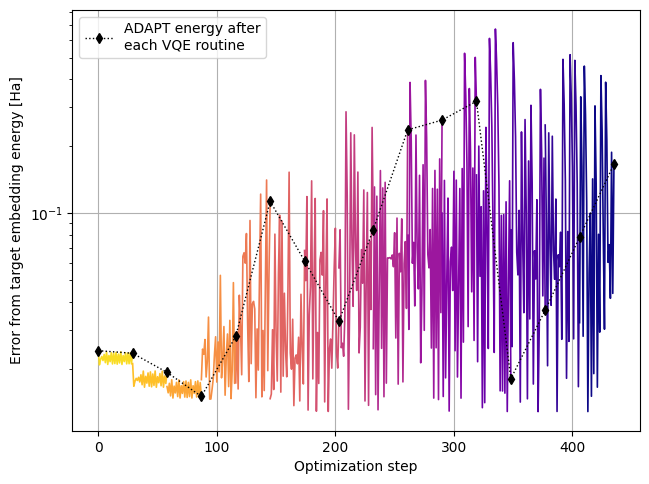

In [7]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
fig.tight_layout()
Y_adapt = [embed_mol.embedded_scf.e_tot]
X_adapt = [0]

# niter = len(out['interim_data']['history'])
niter=len(adapt_result['interim_data'].keys())-1
offset=0
prev = 0
colors=[]
for i in range(1,niter+1):
    c = plt.cm.plasma_r(i/niter)
    colors.append(c)
    # i = str(i)
    # params   = out['interim_data'][i]['history']['params']
    energy   = adapt_result['interim_data'][i]['history']['energy']
    gradient = adapt_result['interim_data'][i]['history']['gradient']
    X, Y = zip(*energy.items())
    Y = np.array(Y)
    X = offset+np.array([int(x) for x in X])
    axis.plot(X, abs(Y+emb_corr-e_pbe), lw=1.2, zorder=10, color=c)
    grad_norm = np.linalg.norm(list(gradient.values()), axis=1)
    offset+=(len(X)-1)
    X_adapt.append(offset)
    Y_adapt.append(adapt_result['interim_data'][i]['output']['fun'])

axis.plot(
    X_adapt, abs(np.array(Y_adapt)+emb_corr-e_pbe), ms=5,
    ls=':', color='black', marker='d', label='ADAPT energy after\neach VQE routine', zorder=10, lw=1
)

axis.set_ylabel('Error from target embedding energy [Ha]')
axis.set_xlabel('Optimization step')
axis.set_yscale('log')
axis.legend()
axis.grid()
plt.show()

You can see that, at each step, ADAPT selects one of the CCSD excitations, appends it to a growing circuit, and reoptimizes the variational parameters through VQE. The final set of excitation generators is:

In [7]:
scipy_step_scaling = 5
# 画出能量随迭代次数变化的图像
plt.figure(figsize=(10, 6))

for method in methods:
    if method == 'SPSA_NaturalGradient' or method == 'NaturalGradient':
        # Plot SPSA and Natural Gradient results with regular iteration steps
        energy_history = [result_histories[method]['energy'][i] for i in result_histories[method]['energy']]
        plt.plot(energy_history, label=method)
    else:
        # Multiply the x-axis (iterations) by the step scaling factor for scipy methods
        energy_history = [result_histories[method]['energy'][i] for i in result_histories[method]['energy']]
        plt.plot([scipy_step_scaling * i for i in range(len(energy_history))], energy_history, label=method)

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy Optimization with Different Methods')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'adapt_result' is not defined

With corresponding quantum circuit:

In [8]:
qc = PauliwordOp_to_QuantumCircuit(
    PauliwordOp.from_list(adapt_result['adapt_operator']), 
    bind_params=False,
    include_barriers=False
)
qc.draw()

┌───┐                                               ┌───┐ ┌─────┐┌───┐»
q_0: ─┤ H ├───■───────────────────────────────────────■───┤ H ├─┤ Sdg ├┤ H ├»
      ├───┤ ┌─┴─┐                                   ┌─┴─┐ ├───┤ ├─────┤├───┤»
q_1: ─┤ H ├─┤ X ├──■─────────────────────────────■──┤ X ├─┤ H ├─┤ Sdg ├┤ H ├»
     ┌┴───┴┐├───┤  │                             │  └───┘ └───┘ └─────┘└───┘»
q_2: ┤ Sdg ├┤ H ├──┼────■────────────────────────┼──────────────────────────»
     └┬───┬┘└───┘  │  ┌─┴─┐                      │                          »
q_3: ─┤ H ├────────┼──┤ X ├──────────────────────┼───────────────────────■──»
     ┌┴───┴┐┌───┐  │  └───┘                      │                       │  »
q_4: ┤ Sdg ├┤ H ├──┼─────────────────────────────┼───────────────────────┼──»
     ├─────┤├───┤  │                             │                       │  »
q_5: ┤ Sdg ├┤ H ├──┼─────────────────────────────┼───────────────────────┼──»
     └┬───┬┘└───┘  │                             │                       │  »
q_6: ─┤ H ├────────┼─────────────────────────────┼───────────────────────┼──»
      ├───┤      ┌─┴─┐                         ┌─┴─┐┌───┐┌─────┐ ┌───┐ ┌─┴─┐»
q_7: ─┤ H ├──────┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ Sdg ├─┤ H ├─┤ X ├»
     ┌┴───┴┐┌───┐└───┘┌─┴─┐┌─────────────┐┌─┴─┐├───┤├───┤├─────┤ ├───┤ └───┘»
q_8: ┤ Sdg ├┤ H ├─────┤ X ├┤ Rz(-2*P[0]) ├┤ X ├┤ H ├┤ S ├┤ Sdg ├─┤ H ├──────»
     └─────┘└───┘     └───┘└─────────────┘└───┘└───┘└───┘└─────┘ └───┘      »
«                                                                   ┌───┐»
«q_0: ──■───────────────────────────────────────────────────────■───┤ H ├»
«     ┌─┴─┐                                                   ┌─┴─┐ ├───┤»
«q_1: ┤ X ├───────■───────────────────────────────────────■───┤ X ├─┤ H ├»
«     └───┘       │                                       │   ├───┤ ├───┤»
«q_2: ────────────┼──────────────────────────────────■────┼───┤ H ├─┤ S ├»
«                 │                                ┌─┴─┐  │   ├───┤ ├───┤»
«q_3: ────────────┼─────────────────────────────■──┤ X ├──┼───┤ H ├─┤ H ├»
«                 │                             │  └───┘  │   └───┘ └───┘»
«q_4: ────────────┼─────────────────────────────┼─────────┼──────────────»
«               ┌─┴─┐                           │       ┌─┴─┐ ┌───┐ ┌───┐»
«q_5: ──────────┤ X ├───────■───────────────────┼────■──┤ X ├─┤ H ├─┤ S ├»
«               └───┘     ┌─┴─┐┌─────────────┐  │  ┌─┴─┐├───┤┌┴───┴┐├───┤»
«q_6: ────────────────────┤ X ├┤ Rz(-2*P[1]) ├──┼──┤ X ├┤ H ├┤ Sdg ├┤ H ├»
«                         └───┘└─────────────┘┌─┴─┐├───┤├───┤└┬───┬┘└───┘»
«q_7: ──■───────────────────■─────────────────┤ X ├┤ H ├┤ S ├─┤ H ├──────»
«     ┌─┴─┐┌─────────────┐┌─┴─┐     ┌───┐     ├───┤├───┤└───┘ └───┘      »
«q_8: ┤ X ├┤ Rz(-2*P[2]) ├┤ X ├─────┤ H ├─────┤ S ├┤ H ├─────────────────»
«     └───┘└─────────────┘└───┘     └───┘     └───┘└───┘                 »
«      ┌───┐ ┌─────┐┌───┐                                                      »
«q_0: ─┤ S ├─┤ Sdg ├┤ H ├──■───────────────────────────────────────────────────»
«      ├───┤ └─────┘└───┘┌─┴─┐                                                 »
«q_1: ─┤ S ├─────────────┤ X ├─────────────────────────────────────────────────»
«     ┌┴───┴┐ ┌───┐      └───┘                                    ┌───┐  ┌───┐ »
«q_2: ┤ Sdg ├─┤ H ├───■───────────────────────────────────────■───┤ H ├──┤ S ├─»
«     └─────┘ └───┘ ┌─┴─┐                                   ┌─┴─┐ ├───┤ ┌┴───┴┐»
«q_3: ──────────────┤ X ├──■─────────────────────────────■──┤ X ├─┤ H ├─┤ Sdg ├»
«                   └───┘  │                             │  └───┘ └───┘ └─────┘»
«q_4: ─────────────────────┼─────────────────────────────┼─────────────────────»
«     ┌─────┐ ┌───┐      ┌─┴─┐                         ┌─┴─┐┌───┐ ┌───┐ ┌─────┐»
«q_5: ┤ Sdg ├─┤ H ├──────┤ X ├──■───────────────────■──┤ X ├┤ H ├─┤ S ├─┤ Sdg ├»
«     └─────┘ └───┘      └───┘┌─┴─┐┌─────────────┐┌─┴─┐├───┤├───┤┌┴───┴┐└┬───┬┘»
«q_6: ────────────────────────┤ X ├┤ Rz(-2*P[3

You can then start applying circuit optimization techniques to reduce the depth, for example using Qiskit's transpiler with ``optimization_level=3``:

In [9]:
from qiskit import transpile
qc.depth(), transpile(qc, optimization_level=3).depth()

(159, 120)